<a href="https://colab.research.google.com/github/karomatusiak/pum_projekt/blob/main/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.feature_selection import RFE
#from sklearn.ensemble import RandomForestClassifier

In [ ]:
# załadowanie danych z pliku CSV, z określeniem separatora jako średnik
data_path = "winequality-white.csv"
df_wine_data = pd.read_csv(data_path, sep=';')
df_wine_data.shape
df_wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   object 
 5   free sulfur dioxide   4898 non-null   object 
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   object 
 10  alcohol               4895 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(8), int64(1), object(3)
memory usage: 459.3+ KB


In [ ]:
df_wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.05,30,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47,186.0,0.9956,3.19,0.4,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47,186.0,0.9956,3.19,0.4,9.9,6


In [ ]:
# usuwamy duplikaty
df_wine_data = df_wine_data.drop_duplicates()

In [ ]:
# usuwanie niepożądanych znaków i konwersja na liczby
for column in df_wine_data.columns:
    df_wine_data[column] = df_wine_data[column].replace('[^0-9.]', '', regex=True).astype(float)

In [ ]:
data_cleaned = df_wine_data.copy()

# usuwanie wartości odstających
for column in data_cleaned.select_dtypes(include=[float, int]).columns:
    Q1 = data_cleaned[column].quantile(0.25)
    Q3 = data_cleaned[column].quantile(0.75)
    IQR = Q3 - Q1

    data_cleaned = data_cleaned.drop(data_cleaned.loc[data_cleaned[column] > (Q3 + 1.5 * IQR)].index)
    data_cleaned = data_cleaned.drop(data_cleaned.loc[data_cleaned[column] < (Q1 - 1.5 * IQR)].index)

In [ ]:
# normalizacja danych
scaler = MinMaxScaler()
numerical_columns = data_cleaned.select_dtypes(include=[float, int]).columns
data_cleaned[numerical_columns] = scaler.fit_transform(data_cleaned[numerical_columns])

data_cleaned.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1,0.375,0.543210,0.522727,0.054054,0.603448,0.157895,0.488987,0.503287,0.623377,0.500000,0.189655,0.666667
2,0.825,0.493827,0.659091,0.340541,0.620690,0.368421,0.334802,0.583638,0.571429,0.407407,0.293103,0.666667
3,0.600,0.370370,0.477273,0.427027,0.758621,0.592105,0.726872,0.620161,0.480519,0.333333,0.258621,0.666667
6,0.350,0.592593,0.113636,0.345946,0.534483,0.368421,0.506608,0.569028,0.467532,0.462963,0.206897,0.666667
9,0.825,0.345679,0.727273,0.048649,0.517241,0.342105,0.475771,0.488678,0.519481,0.425926,0.448276,0.666667


## **Korelacja cech numerycznych**

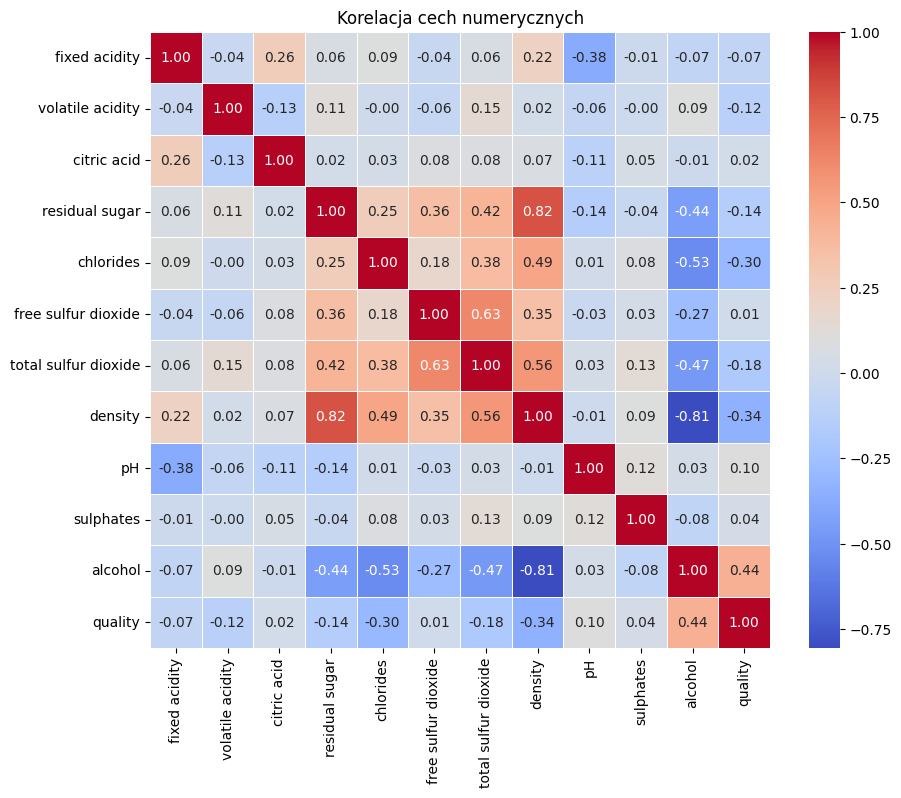

In [ ]:
corr = data_cleaned.corr()

# generowanie heatmapy korelacji cech numerycznych
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Korelacja cech numerycznych')
plt.show()

## **Ranking cech z korelacjami**

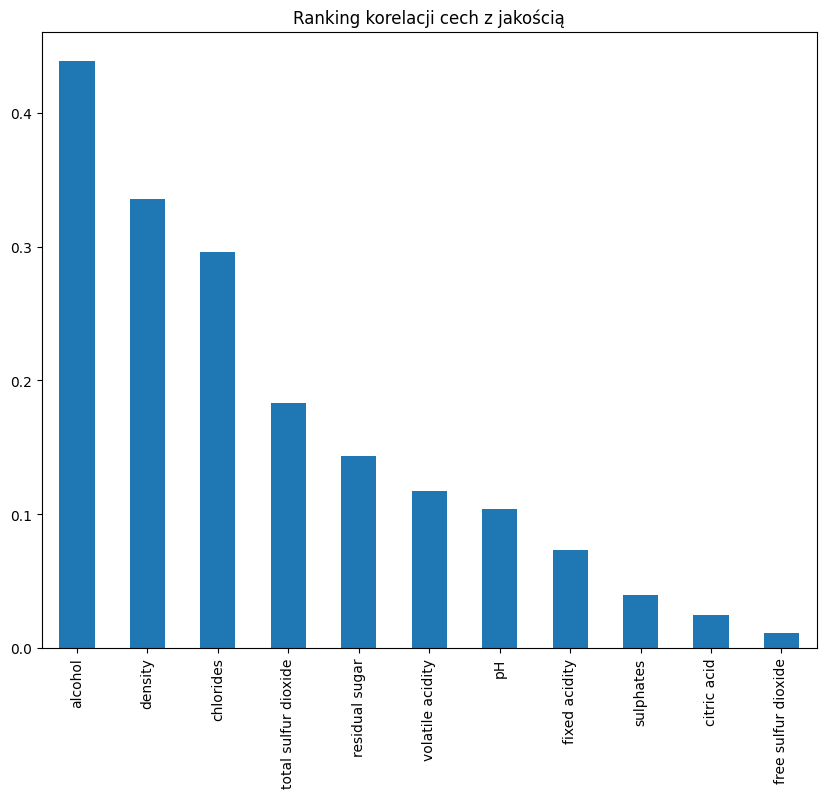

In [ ]:
# obliczenie korelacji wszystkich cech z cechą 'quality'
corr_with_quality = data_cleaned.corr()['quality'].drop('quality').abs()

# ranking korelacji i wyświetlenie go na wykresie słupkowym
corr_with_quality_sorted = corr_with_quality.sort_values(ascending=False)
corr_with_quality_sorted.plot.bar(figsize=(10, 8))
plt.title('Ranking korelacji cech z jakością')
plt.show()

In [ ]:
# usunięcie 2 cech najmniej skorelowanych
# znalezienie nazw dwóch ostatnich cech w posortowanym DataFrame
features_to_drop = corr_with_quality_sorted.nsmallest(2).index

# utworzenie nowego DataFrame bez dwóch najmniej skorelowanych cech
data_cleaned_reduced = data_cleaned.drop(columns=features_to_drop)

# wyświetlenie pozostałych cech
print("Pozostałe cechy:", data_cleaned_reduced.columns)

Pozostałe cechy: Index(['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality'],
      dtype='object')


In [ ]:
data_cleaned_reduced = data_cleaned_reduced.dropna()

## **Analiza głównych składowych (PCA)**

In [ ]:
# wybranie kolumn numerycznych (z wyłączeniem celu)
features = data_cleaned_reduced.columns.difference(['quality'])

# wykonanie PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data_cleaned_reduced[features])

# wizualizacja wyników PCA
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel('Pierwsza główna składowa')
plt.ylabel('Druga główna składowa')
plt.title('PCA - Projekcja na dwie główne składowe')
plt.show()

In [ ]:
# https://colab.research.google.com/github/UEPP40/PUM/blob/urbanowicz/projekt/preprocessing.ipynb#scrollTo=AKPktrJCeJQJ